### Cryptocurrency trading-pair forecasting, using machine learning and deep learning Technique - *Osifo Ernest and Ritabrata Bhattacharyya* 

###### An effort to recreate the research findings

### 1. Fetching the required data 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import yfinance as yf 
%matplotlib inline 
import seaborn as sns 
np.random.seed(0) 
plt.style.use('seaborn-v0_8-dark') 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint 
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM

from pmdarima.arima import auto_arima 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) 

import scipy 

import pandas_datareader as pdr 
from datetime import datetime 
import statsmodels.regression.linear_model as rg 
import arch.unitroot as at 

import warnings 
warnings.filterwarnings('ignore') 

In [2]:
start_date = '2018-01-01'
end_date = '2019-09-01' 

assets = ['BTC-USD','ETH-USD','XRP-USD','BCH-USD','USDT-USD','LTC-USD','EOS-USD','BNB-USD','XLM-USD']

In [3]:
data = pd.DataFrame() 

for ticker in assets:
    tick = ticker.split('-USD')[0]  
    data[f'{tick}_ADJ'] = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head() 

,BTC_ADJ,ETH_ADJ,XRP_ADJ,BCH_ADJ,USDT_ADJ,LTC_ADJ,EOS_ADJ,BNB_ADJ,XLM_ADJ
Date,,,,,,,,,
2018-01-01,13657.200195,772.640991,2.39103,2432.540039,1.007280,229.033005,8.84318,8.41461,0.480008
2018-01-02,14982.099609,884.443970,2.48090,2711.000000,1.004900,255.684006,9.33471,8.83777,0.564766
2018-01-03,15201.000000,962.719971,3.10537,2608.689941,1.013440,245.367996,10.22790,9.53588,0.896227
2018-01-04,15599.200195,980.921997,3.19663,2430.179932,1.002530,241.369995,11.27550,9.21399,0.724050
2018-01-05,17429.500000,997.719971,3.04871,2584.479980,0.998634,249.270996,10.83960,14.91720,0.662712


### 2. Visualizing the performance of cryptocurrencies

Normalizing prices by first value

In [5]:
norm_prices = data.divide(data.iloc[0]) 
norm_prices.head() 

,BTC_ADJ,ETH_ADJ,XRP_ADJ,BCH_ADJ,USDT_ADJ,LTC_ADJ,EOS_ADJ,BNB_ADJ,XLM_ADJ
Date,,,,,,,,,
2018-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-02,1.097011,1.144702,1.037586,1.114473,0.997637,1.116363,1.055583,1.050289,1.176576
2018-01-03,1.113039,1.246012,1.298758,1.072414,1.006116,1.071322,1.156586,1.133253,1.867108
2018-01-04,1.142196,1.269570,1.336926,0.999030,0.995284,1.053866,1.275050,1.094999,1.508412
2018-01-05,1.276213,1.291311,1.275061,1.062461,0.991416,1.088363,1.225758,1.772774,1.380627


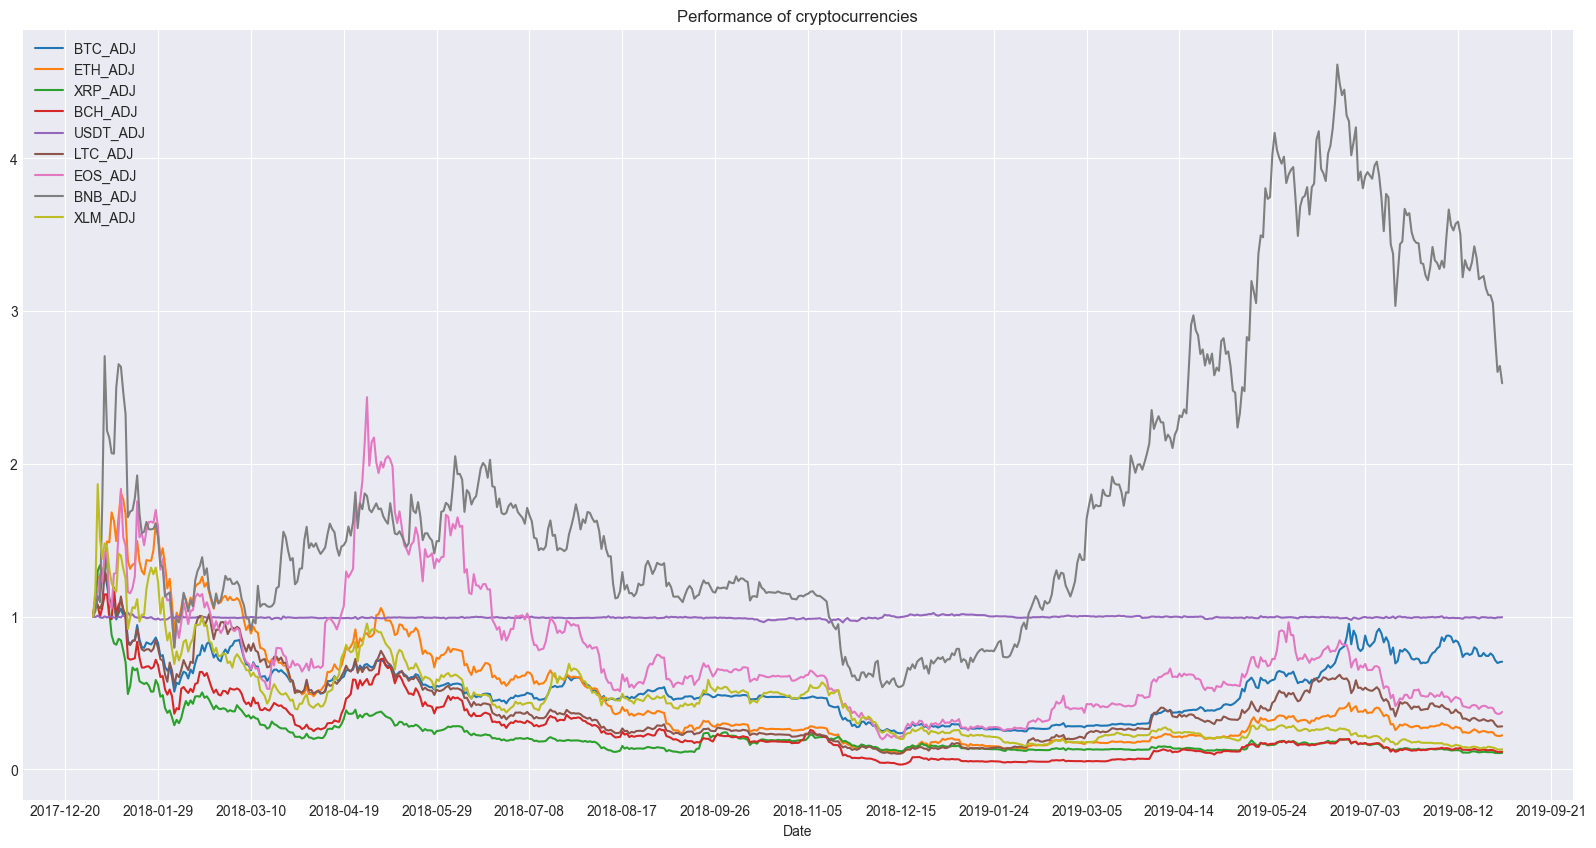

In [6]:
Norm_assets = data.columns 

plt.figure(figsize=(20,10)) 
# plt.xticks(rotation=90) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(norm_prices) 
plt.title('Performance of cryptocurrencies') 
plt.legend(Norm_assets,loc='best') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.show() 

In the given time interval, some currencies tend to outperform others. 

#### Normalizing dataframe (dt) 

In [7]:
def normalize_series(data):
    return data.pct_change(1).dropna() 

dt = normalize_series(data) 
dt = dt.tail(len(dt)-1) 
dt.columns = ['BTC_RET','ETH_RET','XRP_RET','BCH_RET','USDT_RET','LTC_RET','EOS_RET','BNB_RET','XLM_RET'] 
dt.head() 

,BTC_RET,ETH_RET,XRP_RET,BCH_RET,USDT_RET,LTC_RET,EOS_RET,BNB_RET,XLM_RET
Date,,,,,,,,,
2018-01-03,0.014611,0.088503,0.251711,-0.037739,0.008498,-0.040347,0.095685,0.078992,0.586900
2018-01-04,0.026196,0.018907,0.029388,-0.068429,-0.010765,-0.016294,0.102426,-0.033756,-0.192113
2018-01-05,0.117333,0.017125,-0.046274,0.063493,-0.003886,0.032734,-0.038659,0.618973,-0.084715
2018-01-06,0.005594,0.044061,0.014846,0.078225,0.010370,0.189284,0.160532,0.525742,0.071272
2018-01-07,-0.059873,0.107029,0.091740,0.000083,-0.007354,-0.026996,-0.004595,-0.180274,-0.014508


#### Normalizing and Calculating cumulative returns (percentage change) for each crypto-currency

In [8]:
def normalize_and_accumulate_series(data):
    return data.pct_change(1).cumsum().dropna() 

dtc = normalize_and_accumulate_series(data) 

dtc = dtc.tail(len(dtc)-1) 
dtc.columns = ['BTC_CRET','ETH_CRET','XRP_CRET','BCH_CRET','USDT_CRET','LTC_CRET','EOS_CRET','BNB_CRET','XLM_CRET'] 
dtc.head() 

,BTC_CRET,ETH_CRET,XRP_CRET,BCH_CRET,USDT_CRET,LTC_CRET,EOS_CRET,BNB_CRET,XLM_CRET
Date,,,,,,,,,
2018-01-03,0.111622,0.233205,0.289297,0.076734,0.006136,0.076016,0.151268,0.129280,0.763476
2018-01-04,0.137818,0.252112,0.318685,0.008305,-0.004630,0.059723,0.253694,0.095525,0.571363
2018-01-05,0.255150,0.269237,0.272411,0.071798,-0.008516,0.092457,0.215034,0.714498,0.486648
2018-01-06,0.260744,0.313298,0.287257,0.150023,0.001854,0.281741,0.375566,1.240240,0.557920
2018-01-07,0.200871,0.420327,0.378997,0.150105,-0.005500,0.254745,0.370972,1.059966,0.543412


#### Plotting percentage change

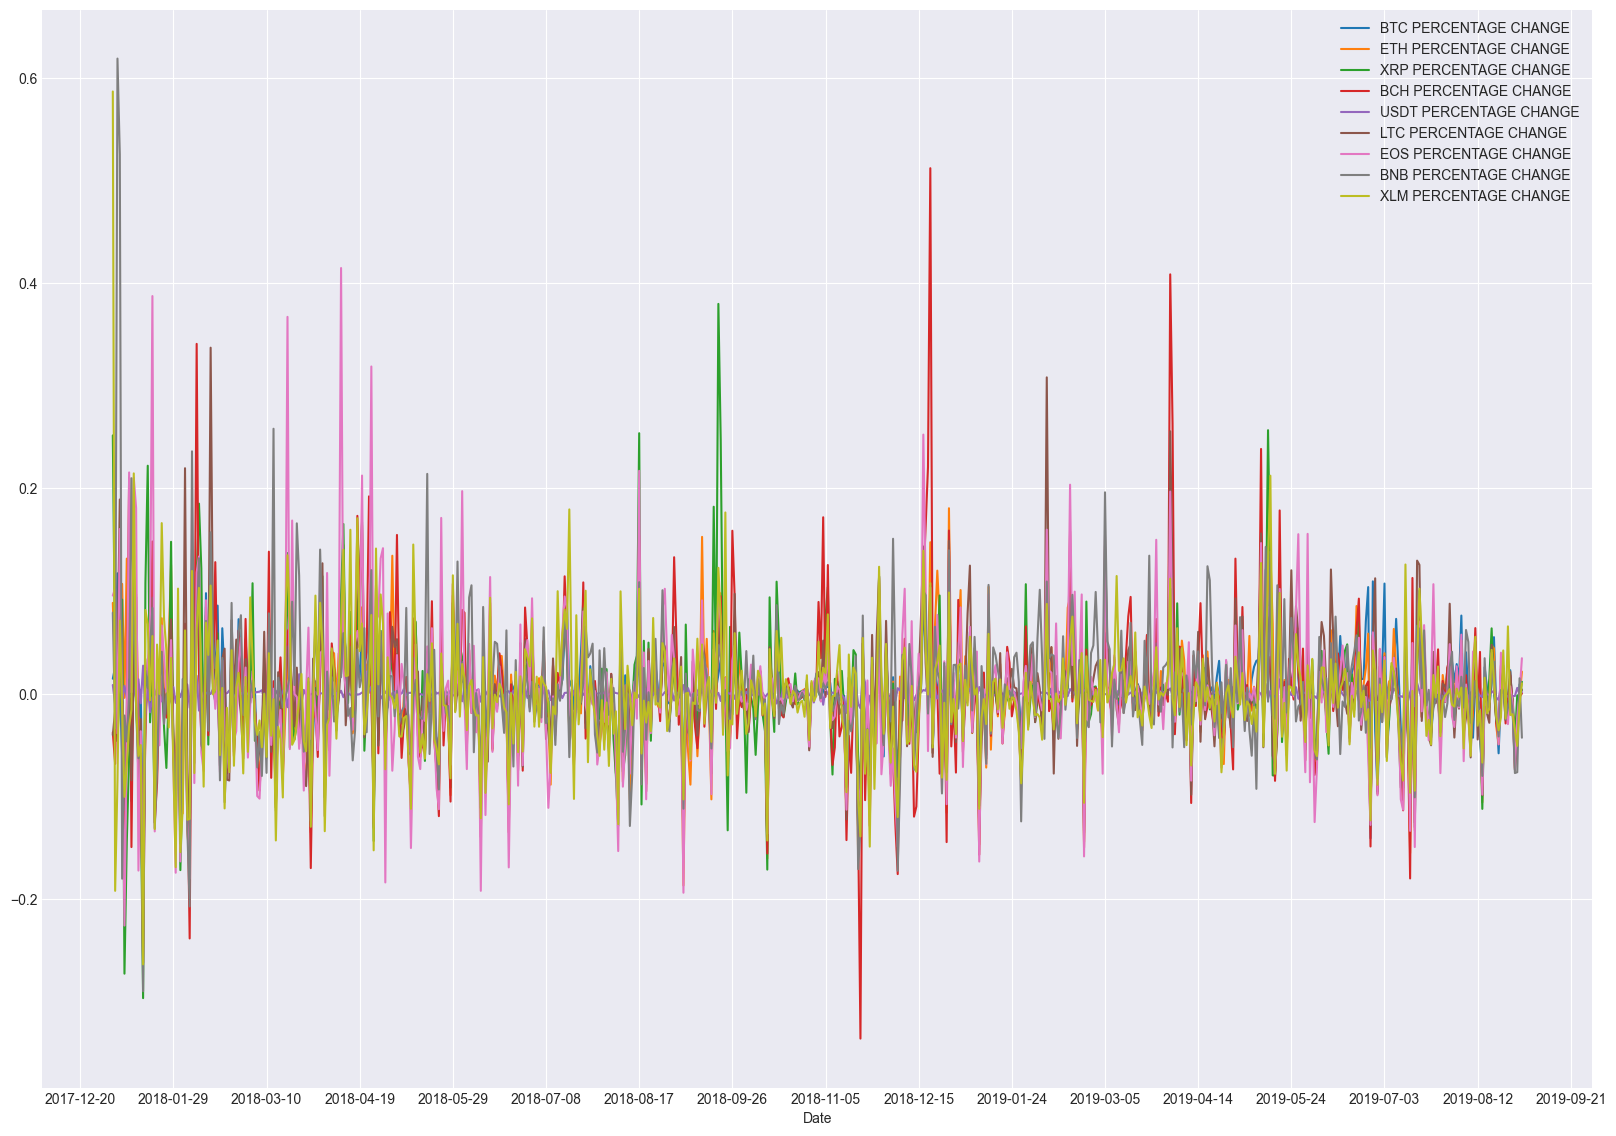

In [9]:
plt.figure(figsize=(20,14)) 
# plt.xticks(rotation=45) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
for name in dt.columns:
    tick = name.split('_RET')[0] 
    plt.plot(dt[name], label=f'{tick} PERCENTAGE CHANGE') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()      

#### Plotting Cumulative returns

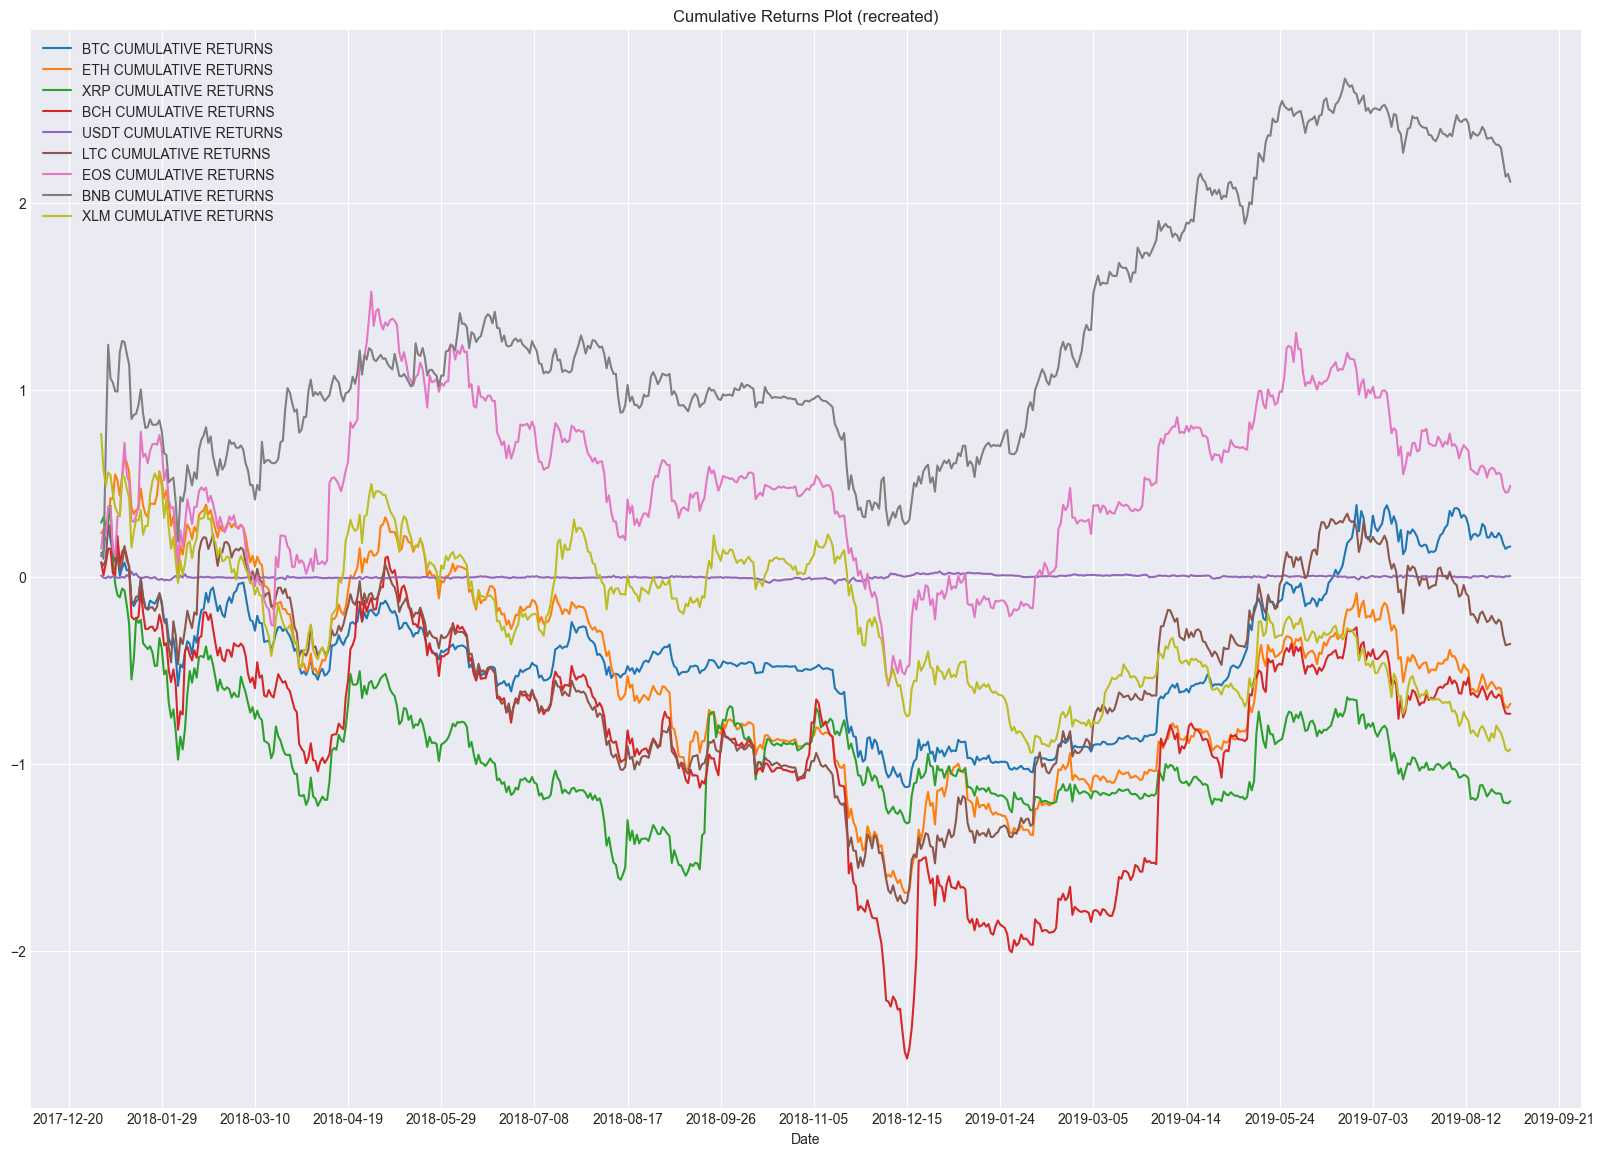

In [10]:
plt.figure(figsize=(20,14)) 
# plt.xticks(rotation=90)
plt.style.use('seaborn-v0_8-dark')  
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
for name in dtc.columns:
    tick = name.split('_CRET')[0] 
    plt.plot(dtc[name], label=f'{tick} CUMULATIVE RETURNS') 
plt.xlabel('Date') 
plt.title('Cumulative Returns Plot (recreated)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()      

Criteria for selecting pairs are by examining correlation and cointegration. 
* Pair with highest correlation is desired pair
* Pair should also exhibit significantly low cointegration. A value less than 0.05 is desired 
* Highly positive correlation indicates pairs are moving in the sam edirection

### Calculating P-value for every possible pair (9 cryptocurrencies are selected) 

In [11]:
p_value = [] 
for x in dt.columns:
    for y in dt.columns:
        if x!=y:
            test_result = ts.coint(dt[x],dt[y]) 
            p_value.append(test_result[1])  
            print(x+' and '+y+': p-value = '+str(test_result[1])) 

BTC_RET and ETH_RET: p-value = 0.0
BTC_RET and XRP_RET: p-value = 2.377387750181754e-29
BTC_RET and BCH_RET: p-value = 1.6325415723933469e-24
BTC_RET and USDT_RET: p-value = 1.8387382129106034e-23
BTC_RET and LTC_RET: p-value = 7.627944123353666e-28
BTC_RET and EOS_RET: p-value = 8.534936035753071e-23
BTC_RET and BNB_RET: p-value = 0.0
BTC_RET and XLM_RET: p-value = 5.979311587938324e-25
ETH_RET and BTC_RET: p-value = 2.688546505680823e-15
ETH_RET and XRP_RET: p-value = 7.0884375077840764e-15
ETH_RET and BCH_RET: p-value = 2.878113138303384e-12
ETH_RET and USDT_RET: p-value = 9.068508165949459e-23
ETH_RET and LTC_RET: p-value = 4.0838318780685e-27
ETH_RET and EOS_RET: p-value = 2.1884807763497907e-24
ETH_RET and BNB_RET: p-value = 1.4540299138712497e-14
ETH_RET and XLM_RET: p-value = 1.2661882542810507e-22
XRP_RET and BTC_RET: p-value = 2.052586237300488e-29
XRP_RET and ETH_RET: p-value = 0.0
XRP_RET and BCH_RET: p-value = 0.0
XRP_RET and USDT_RET: p-value = 0.0
XRP_RET and LTC_RET: p-

In [12]:
result = []
for res in p_value:
    if res<0.05:
        result.append(res) 

print(f'Out of {len(p_value)} values, {len(result)} values pass the test') 

Out of 72 values, 72 values pass the test


Here, we can see, p-values of all pairs are less than 0.05. Therefore, we have to do the correlation test

Correlation is defined as the degree to which the pair tend to move together

#### Defining Correlation function

In [13]:
def corrltn(data1,data2):
    mean1 = data1.mean() 
    mean2 = data2.mean() 
    std1 = data1.std() 
    std2 = data2.std()
    corr = ((data1*data2).mean()-mean1*mean2)/(std1*std2) 
    return corr 

Implemeting Correlation on pair BTC and other cryptocurrencies

In [14]:
co_rrelation = dict() 
stock_name_1 = 'BTC_RET' 
stock_name_2 = ['ETH_RET', 'XRP_RET', 'BCH_RET', 'USDT_RET', 'LTC_RET',
       'EOS_RET', 'BNB_RET','XLM_RET']  

for stock in stock_name_2:
    score,pvalue,_ = coint(dt[stock_name_1],dt[stock]) 
    correlation = corrltn(dt[stock_name_1],dt[stock]) 
    st_name = stock.split('_RET')[0] 
    co_rrelation[st_name] = correlation 
    print(f'correlation between {stock_name_1} and {stock} is {correlation:.6f}') 
    print(f'cointegration between {stock_name_1} and {stock} is {pvalue:.6f}')   
    print(' ')    

correlation between BTC_RET and ETH_RET is 0.811601
cointegration between BTC_RET and ETH_RET is 0.000000
 
correlation between BTC_RET and XRP_RET is 0.666299
cointegration between BTC_RET and XRP_RET is 0.000000
 
correlation between BTC_RET and BCH_RET is 0.759461
cointegration between BTC_RET and BCH_RET is 0.000000
 
correlation between BTC_RET and USDT_RET is 0.173986
cointegration between BTC_RET and USDT_RET is 0.000000
 
correlation between BTC_RET and LTC_RET is 0.784705
cointegration between BTC_RET and LTC_RET is 0.000000
 
correlation between BTC_RET and EOS_RET is 0.689638
cointegration between BTC_RET and EOS_RET is 0.000000
 
correlation between BTC_RET and BNB_RET is 0.580083
cointegration between BTC_RET and BNB_RET is 0.000000
 
correlation between BTC_RET and XLM_RET is 0.652003
cointegration between BTC_RET and XLM_RET is 0.000000
 


Correlation Matrix and Heat Map

In [15]:
corr_matrix = dt.corr() 
dt.corr() 

,BTC_RET,ETH_RET,XRP_RET,BCH_RET,USDT_RET,LTC_RET,EOS_RET,BNB_RET,XLM_RET
BTC_RET,1.000000,0.812942,0.667400,0.760716,0.174274,0.786002,0.690778,0.581042,0.653081
ETH_RET,0.812942,1.000000,0.750235,0.756858,0.103541,0.812240,0.736737,0.555171,0.708853
XRP_RET,0.667400,0.750235,1.000000,0.623467,0.023370,0.678492,0.674875,0.454398,0.745556
BCH_RET,0.760716,0.756858,0.623467,1.000000,0.092518,0.753170,0.670311,0.480798,0.595612
USDT_RET,0.174274,0.103541,0.023370,0.092518,1.000000,0.105778,0.039450,0.089682,0.126550
LTC_RET,0.786002,0.812240,0.678492,0.753170,0.105778,1.000000,0.716406,0.585072,0.629457
EOS_RET,0.690778,0.736737,0.674875,0.670311,0.039450,0.716406,1.000000,0.505097,0.635041
BNB_RET,0.581042,0.555171,0.454398,0.480798,0.089682,0.585072,0.505097,1.000000,0.470893
XLM_RET,0.653081,0.708853,0.745556,0.595612,0.126550,0.629457,0.635041,0.470893,1.000000


<Axes: >

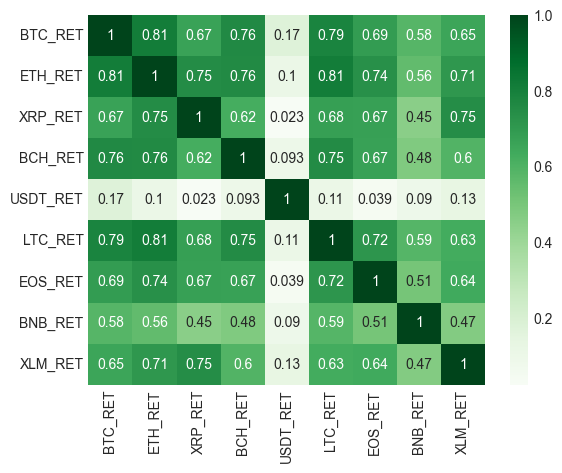

In [16]:
sns.heatmap(corr_matrix, annot=True, cmap='Greens')  

#### Selecting Cryptocurrency pair

In [17]:
sorted_co_rrelation = dict(sorted(co_rrelation.items(), key=lambda item:item[1],reverse=True)) 
sorted_co_rrelation 

{'ETH': 0.811600635932039,
 'LTC': 0.7847052793981729,
 'BCH': 0.7594607812756379,
 'EOS': 0.6896380268689986,
 'XRP': 0.6662985622869438,
 'XLM': 0.6520030911647829,
 'BNB': 0.5800827606193579,
 'USDT': 0.1739863937411107}

Here, we can see, Ethereum (ETH) has the best correlation value (81.2%). Thus, the pair we consider is Bitcoin/Ethereum pair.

#### Forecasting Adjusted Price for Selected Pair

In [18]:
btc = yf.download('BTC-USD',start=start_date,end=end_date) 
eth = yf.download('ETH-USD',start=start_date,end=end_date) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [19]:
btc.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


In [20]:
eth.head() 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128
2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760
2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936
2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776
2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824


In [21]:
print('Shape of btc' ,btc.shape)
print('Shape of eth' ,eth.shape)

Shape of btc (608, 6)
Shape of eth (608, 6)


In [22]:
crypto_pair = pd.DataFrame(index=btc.index) 
crypto_pair['Date'] = btc.index 
crypto_pair['BTC_Adj_Close'] = btc['Adj Close'] 
crypto_pair['ETH_Adj_Close'] = eth['Adj Close'] 

In [23]:
crypto_pair.head() 

,Date,BTC_Adj_Close,ETH_Adj_Close
Date,,,
2018-01-01,2018-01-01,13657.200195,772.640991
2018-01-02,2018-01-02,14982.099609,884.443970
2018-01-03,2018-01-03,15201.000000,962.719971
2018-01-04,2018-01-04,15599.200195,980.921997
2018-01-05,2018-01-05,17429.500000,997.719971


#### Plotting Adj Close Price of BTC and ETH

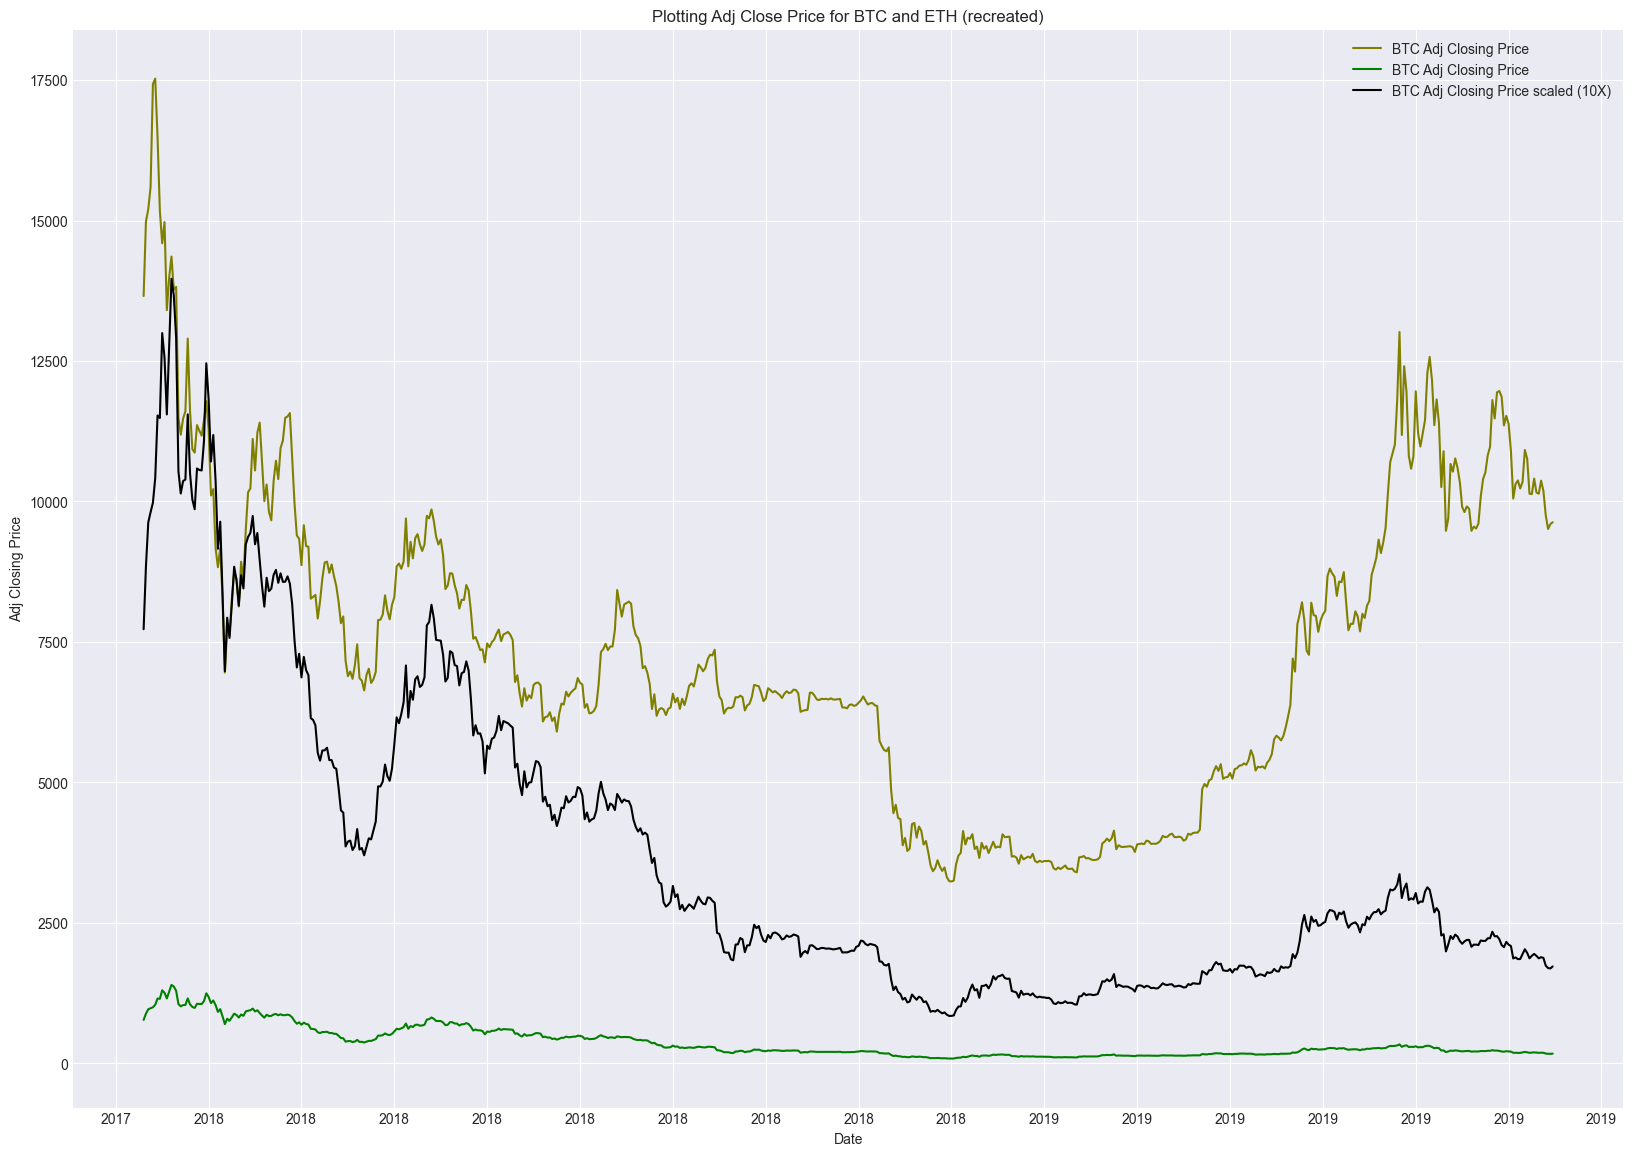

In [24]:
eth_scaling_factor = 10 

plt.figure(figsize=(20,14)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(crypto_pair['BTC_Adj_Close'],color='olive',label='BTC Adj Closing Price') 
plt.plot(crypto_pair['ETH_Adj_Close'],color='green',label='BTC Adj Closing Price') 
plt.plot(crypto_pair['ETH_Adj_Close']*eth_scaling_factor,color='black',label='BTC Adj Closing Price scaled (10X)') 
plt.xlabel('Date') 
plt.ylabel('Adj Closing Price') 
plt.title('Plotting Adj Close Price for BTC and ETH (recreated)')
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 

#### Plotting Returns for BTC and ETH

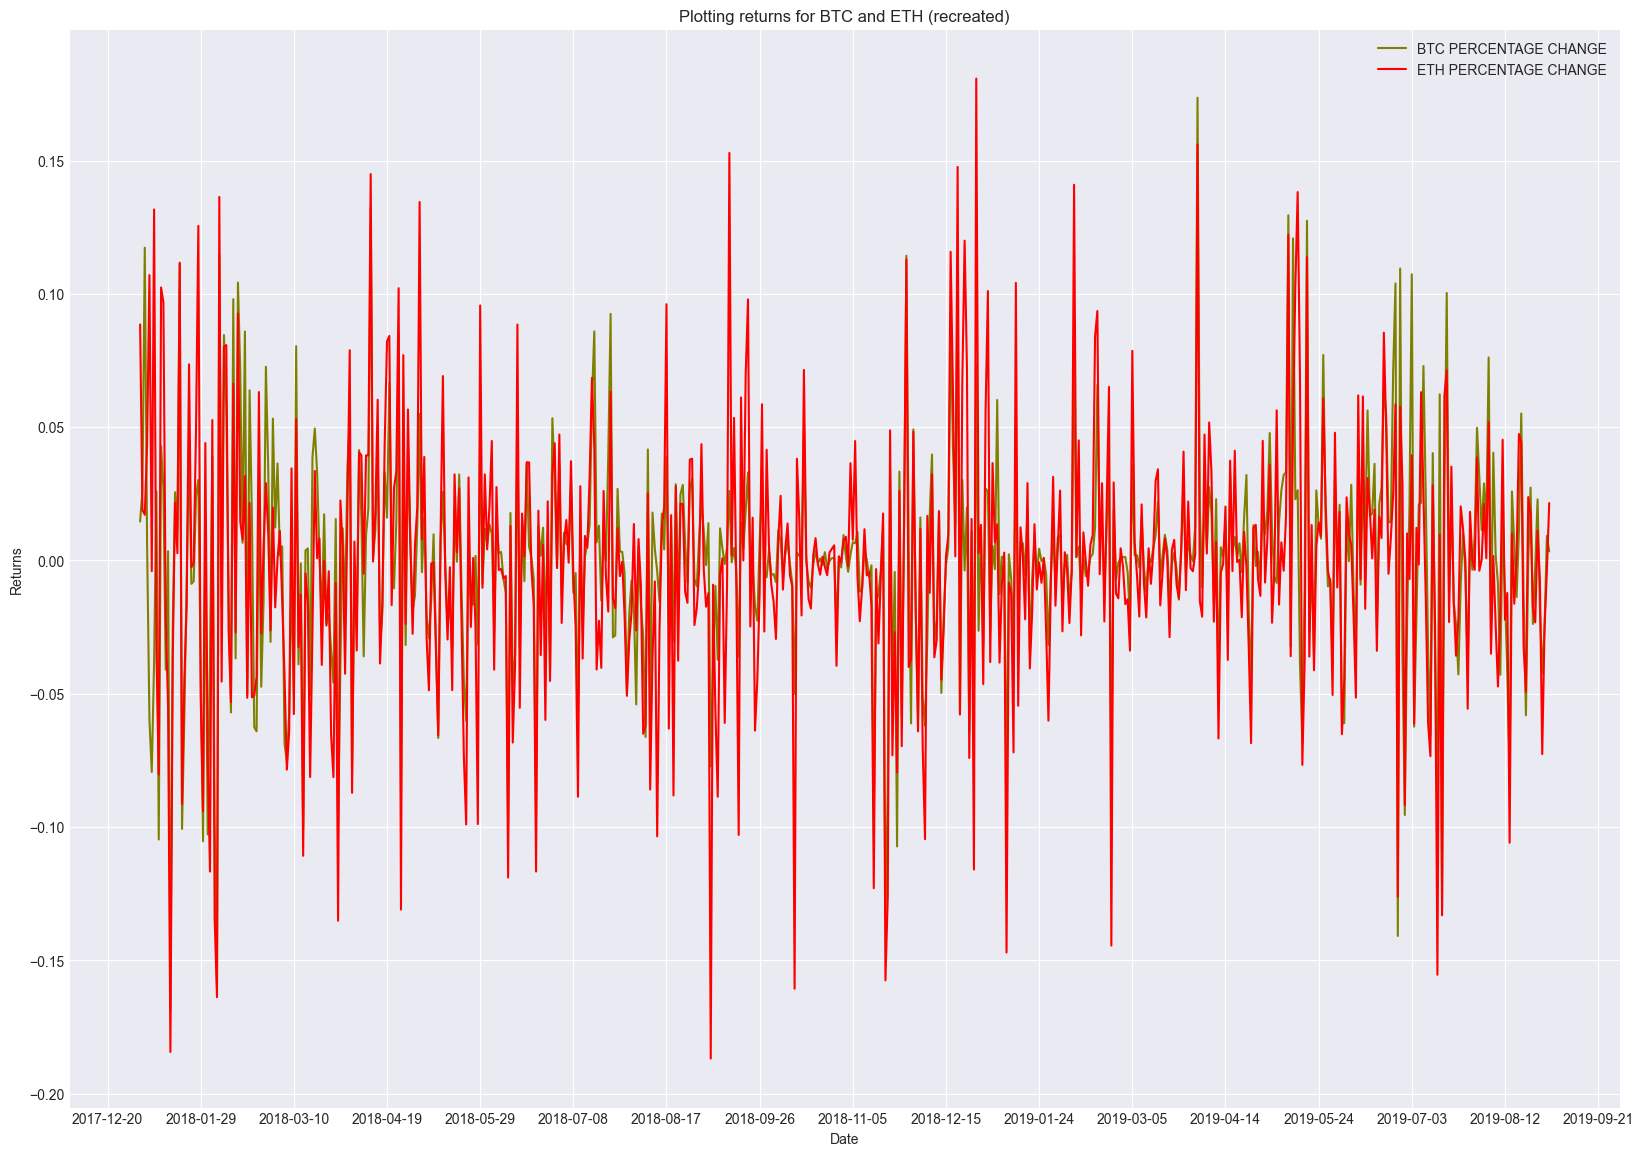

In [25]:
plt.figure(figsize=(20,14)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(dt['BTC_RET'],color='olive',label='BTC PERCENTAGE CHANGE') 
plt.plot(dt['ETH_RET'],color='red',label='ETH PERCENTAGE CHANGE') 
plt.xlabel('Date') 
plt.ylabel('Returns') 
plt.title('Plotting returns for BTC and ETH (recreated)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 

#### Plotting cumulative returns of BTC and ETH

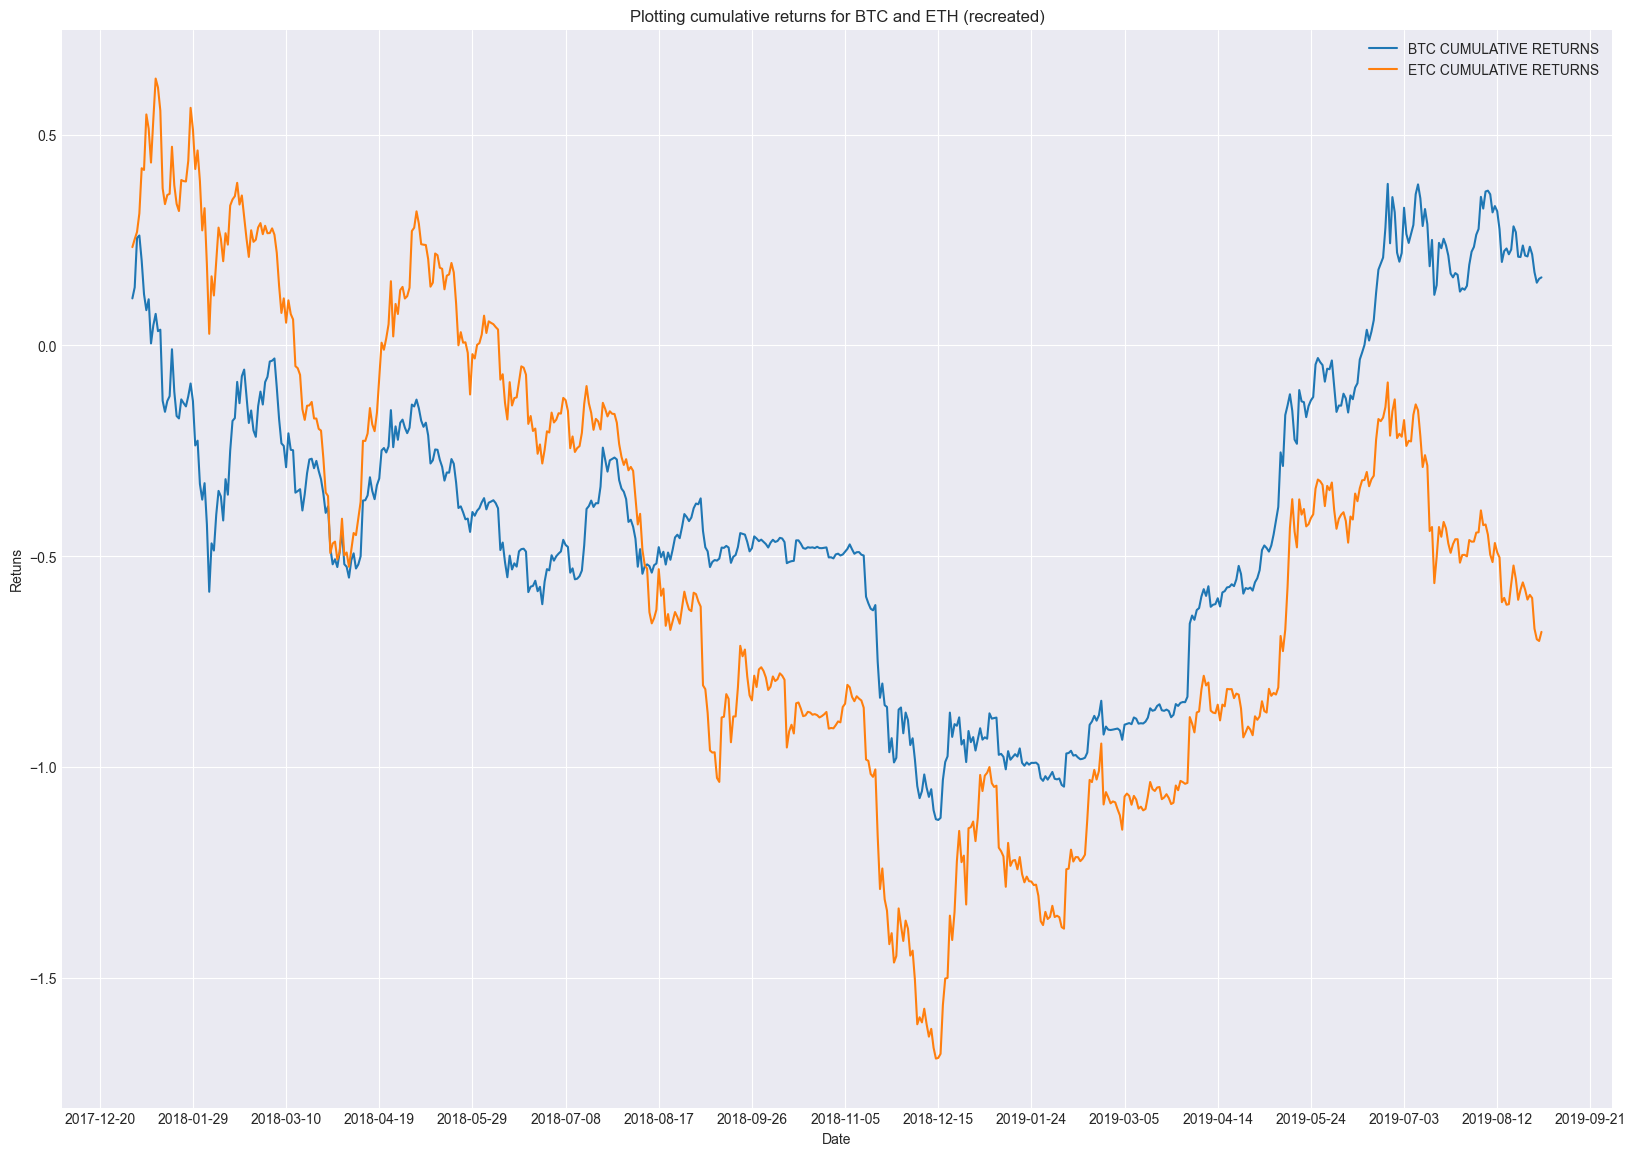

In [26]:
plt.figure(figsize=(20,14)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(dtc['BTC_CRET'],label='BTC CUMULATIVE RETURNS')
plt.plot(dtc['ETH_CRET'],label='ETC CUMULATIVE RETURNS')
plt.xlabel('Date') 
plt.ylabel('Retuns') 
plt.title('Plotting cumulative returns for BTC and ETH (recreated)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 

#### Calculating spread of BTC-ETH Pair

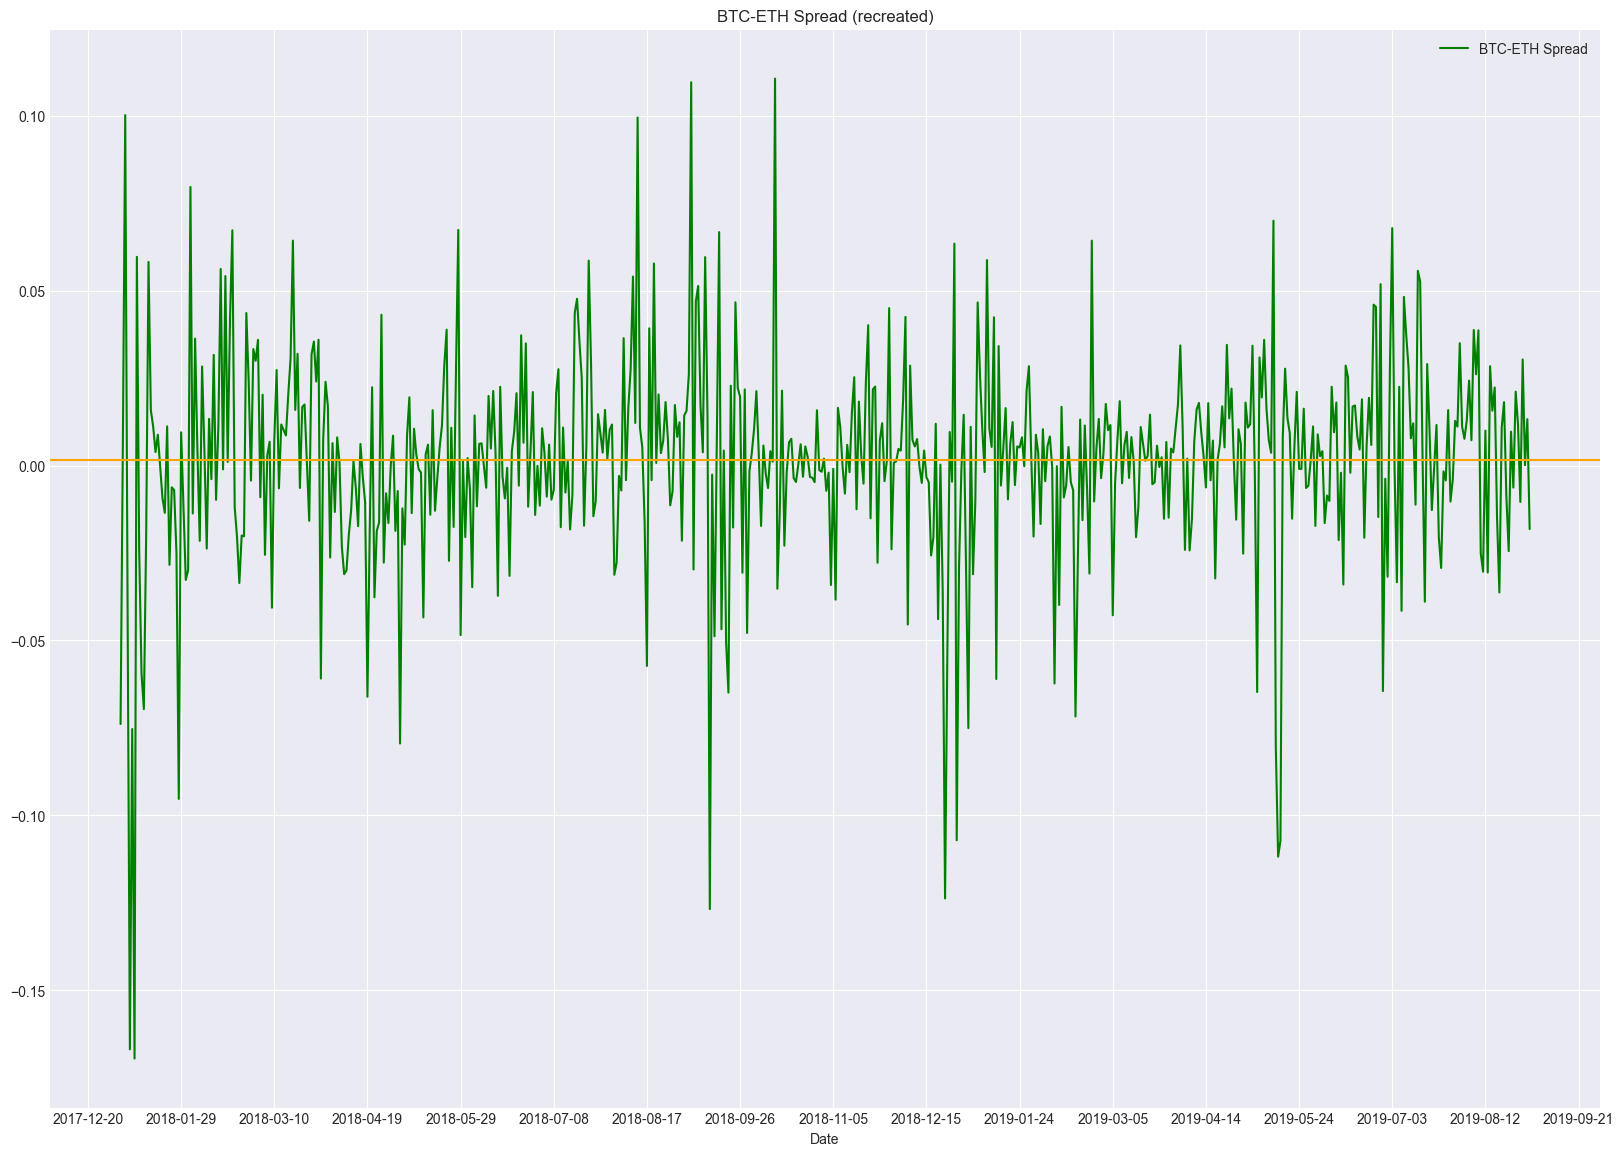

In [27]:
BTC_ETH = dt['BTC_RET']-dt['ETH_RET'] 

plt.figure(figsize=(20,14)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(BTC_ETH, color='green', label='BTC-ETH Spread') 
plt.title('BTC-ETH Spread (recreated)') 
ax.axhline(BTC_ETH.mean(),color='orange') 
ax.grid(True) 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.legend(loc='best') 
plt.show() 

#### Scaling and Splitting BTC Adj Close Price into train and test dataset

In [28]:
BTC_AdjClose = pd.DataFrame()
BTC_AdjClose['Adj_Close'] = btc['Adj Close'] 

BTC_train = BTC_AdjClose[:488] 
BTC_test = BTC_AdjClose[488:] 

print('Shape of training set: ',BTC_train.shape) 
print('Shape of testing set: ',BTC_test.shape)  

Shape of training set:  (488, 1)
Shape of testing set:  (120, 1)


#### Models used are 
1. LSTM
2. Moving Average
3. ARIMA

### Long Short-Term Memory (LSTM)

It is a Recurrent Neural Network (RNN) designed to detect sequence patterns.

In [29]:
np.random.seed(0) 
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(BTC_AdjClose)  

In [30]:
x_train, y_train = [],[] 
for i in range(80,len(BTC_train)):
    x_train.append(scaled_data[i-80:i,0]) 
    y_train.append(scaled_data[i,0]) 
x_train, y_train = np.array(x_train), np.array(y_train) 

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1)) 
x_train.shape 

(408, 80, 1)

#### Defining and Fitting LSTM network

In [31]:
model = Sequential() 
model.add(LSTM(units=13, return_sequences=True, input_shape=(x_train.shape[1],1))) 
model.add(LSTM(units=3)) 
model.add(Dense(1)) 
model.summary() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 13)            780       
                                                                 
 lstm_1 (LSTM)               (None, 3)                 204       
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 988 (3.86 KB)
Trainable params: 988 (3.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy']) 
model.fit(x_train,y_train,epochs=13,batch_size=1,verbose=2) 


Epoch 1/13


408/408 - 8s - loss: 0.0030 - accuracy: 0.0025 - 8s/epoch - 20ms/step
Epoch 2/13
408/408 - 6s - loss: 0.0015 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 3/13
408/408 - 6s - loss: 0.0010 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 4/13
408/408 - 6s - loss: 9.2679e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 5/13
408/408 - 6s - loss: 7.5294e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 6/13
408/408 - 6s - loss: 6.9117e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 7/13
408/408 - 6s - loss: 5.6446e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 8/13
408/408 - 6s - loss: 5.1243e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 9/13
408/408 - 6s - loss: 5.1673e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 10/13
408/408 - 6s - loss: 5.0308e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 11/13
408/408 - 6s - loss: 4.0379e-04 - accuracy: 0.0025 - 6s/epoch - 14ms/step
Epoch 12/13
408/408 - 6s - loss: 4.3288e-04 - accuracy: 0.0025 - 6s/epoc

#### Predicting 122 values using past 80 from the train data

In [33]:
inputs = BTC_AdjClose[len(BTC_AdjClose)-len(BTC_test)-80:].values 
inputs = inputs.reshape(-1,1) 
inputs = scaler.transform(inputs) 

In [34]:
x_test = [] 
for i in range(80,inputs.shape[0]):
    x_test.append(inputs[i-80:i,0]) 
x_test = np.array(x_test) 
print(x_test.shape) 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1)) 
closing_price = model.predict(x_test) 
closing_price = scaler.inverse_transform(closing_price)     

(120, 80)
4/4 [==============================] - 1s 7ms/step


In [36]:
# RMSE for LSTM
rmse = np.sqrt(np.mean(np.power((BTC_test['Adj_Close'].values-closing_price),2)))
print('RMSE for LSTM : ',rmse) 

# MAPE for LSTM
mape = np.mean(np.abs(closing_price-BTC_test['Adj_Close'].values)/np.abs(BTC_test['Adj_Close'].values)) 
print('MAPE for LSTM : ',mape) 

# MPE for LSTM 
mpe = np.mean((closing_price-BTC_test['Adj_Close'].values)/BTC_test['Adj_Close'].values) 
print('MPE for LSTM : ',mpe)  

RMSE for LSTM :  2276.622256471892
MAPE for LSTM :  0.19830926860472656
MPE for LSTM :  -0.017761916348219036


#### Plotting of Forecast by LSTM

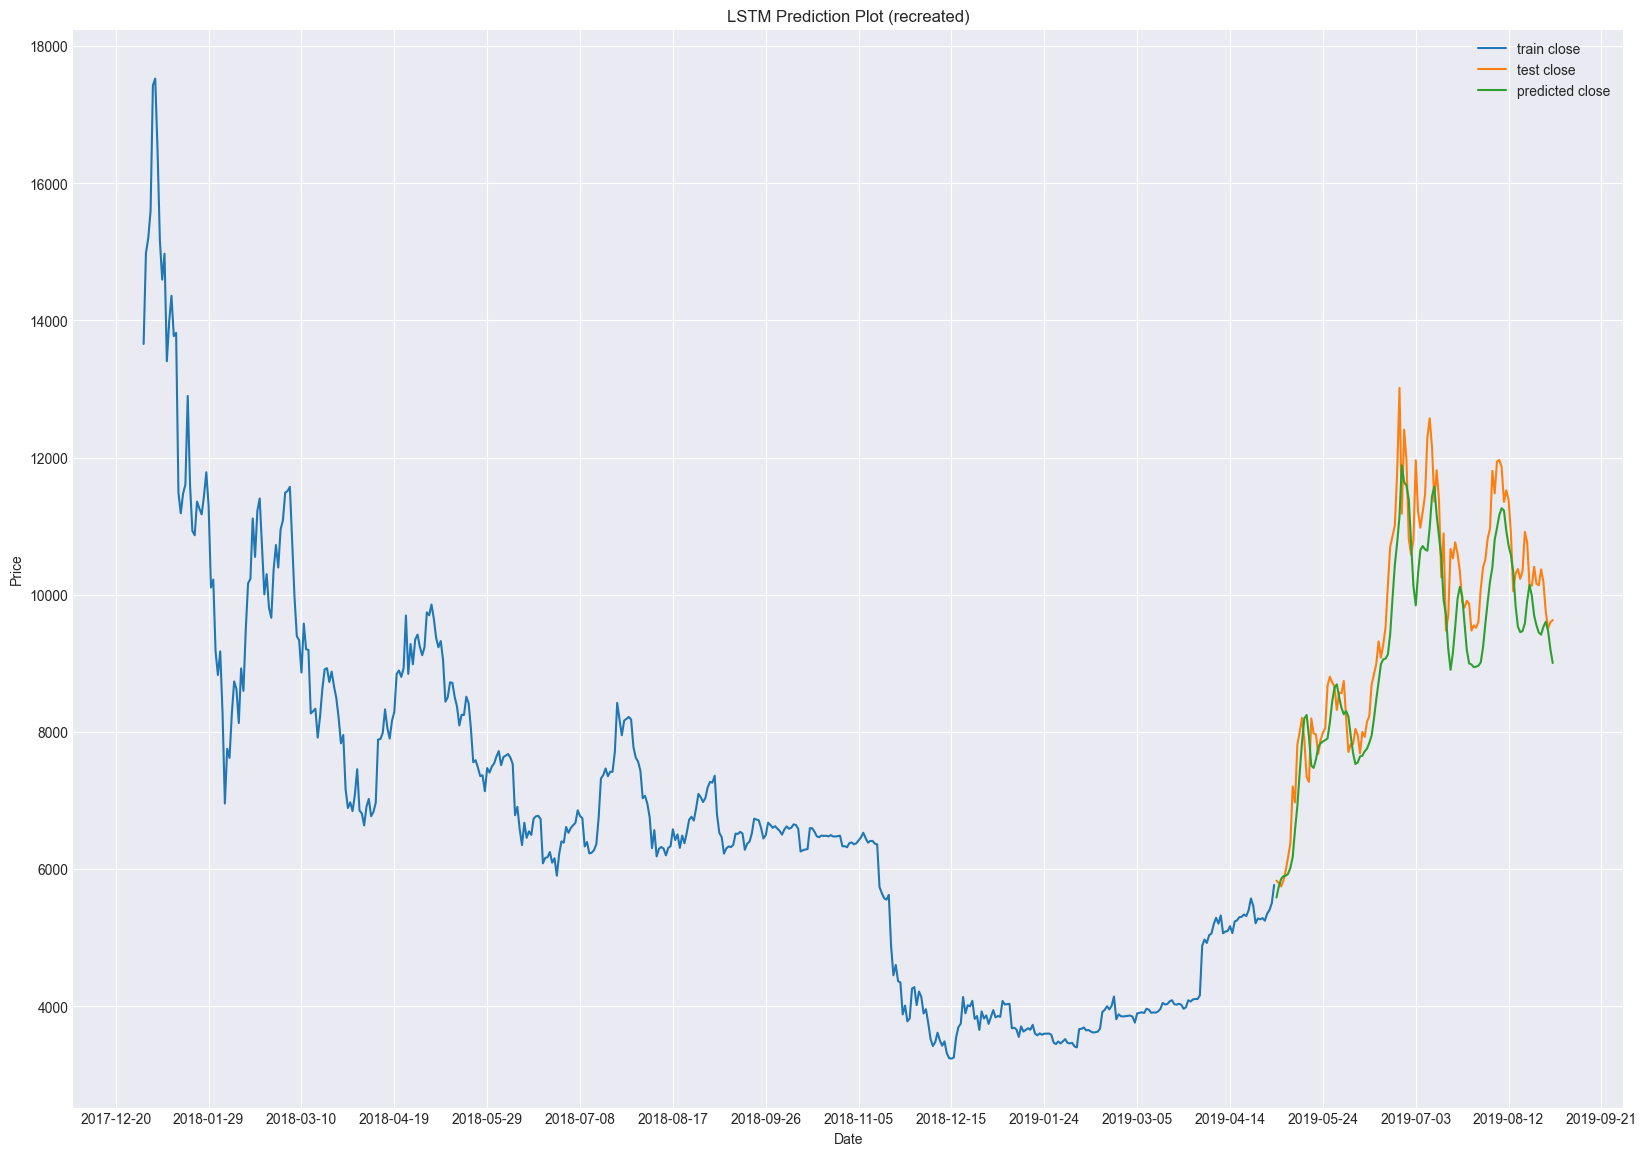

In [39]:
plt.figure(figsize=(20,14)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
BTC_test['LSTM_Predictions'] = closing_price 
plt.plot(BTC_train['Adj_Close'],label='train close') 
plt.plot(BTC_test['Adj_Close'],label='test close') 
plt.plot(BTC_test['LSTM_Predictions'],label='predicted close') 
plt.title('LSTM Prediction Plot (recreated)') 
plt.xlabel('Date') 
plt.ylabel('Price') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
ax.grid(True) 
plt.legend(loc='best') 
plt.show()  

#### Correlation between predicted via LSTm and the actual

In [40]:
corr_LSTM = np.corrcoef(BTC_test['LSTM_Predictions'].dropna().values,BTC_test['Adj_Close'].dropna().values)[0,1] 
print(f'correlation between test-closing and LSTM-predicted-closing : {corr_LSTM}')

correlation between test-closing and LSTM-predicted-closing : 0.9513194473277374


#### Results from LSTM Model

1. RMSE = 2276.622256471892
2. MAPE = 0.19830926860472656
3. MPE = -0.017761916348219036
4. Correlation = 95.13%

We need to investigate other models too to see if we can get better results

For next two models we have to calculate **Auto Correlation Function (ACF)** and **Partial Auto Correlation Function (PACF)** to measure the level of correlation of a particular time series with a previous time. This is the important part of Moving-Average and ARIMA model

#### ACF for Bitcoin Returns

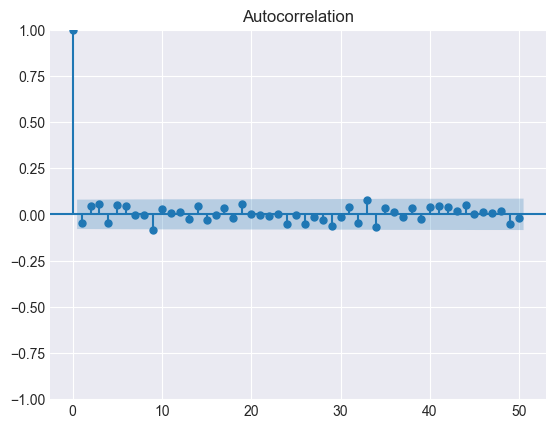

In [44]:
plot_acf(dt['BTC_RET'],lags=50) 
plt.grid(True) 
plt.show() 

#### PACF for Bitcoin Returns

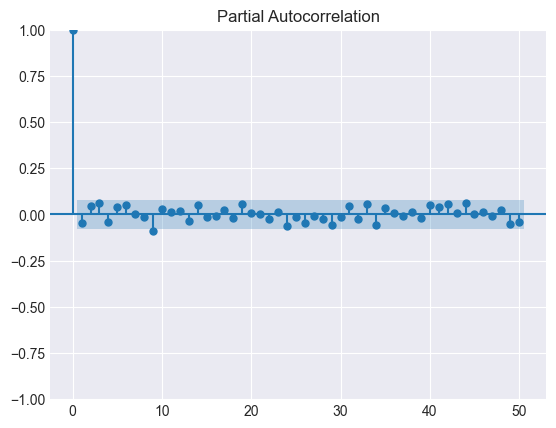

In [43]:
plot_pacf(dt['BTC_RET'],lags=50) 
plt.grid(True) 
plt.show() 

Square the returns, then plot ACF and PACF again

In [45]:
BTC_RET_SQ = dt['BTC_RET']**2 
BTC_RET_SQ.head() 

Date
2018-01-03    0.000213
2018-01-04    0.000686
2018-01-05    0.013767
2018-01-06    0.000031
2018-01-07    0.003585
Name: BTC_RET, dtype: float64

#### ACF for Bitcoin Returns Squared

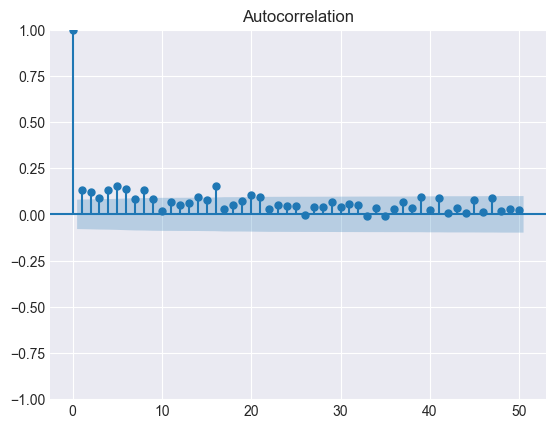

In [47]:
plot_acf(BTC_RET_SQ,lags=50) 
plt.grid(True) 
plt.show() 

#### PACF for Bitcoin Returns Squared

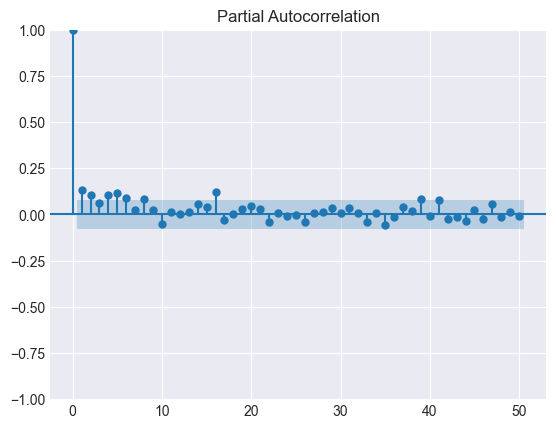

In [48]:
plot_pacf(BTC_RET_SQ,lags=50) 
plt.grid(True) 
plt.show()  

ACF and PACF suggests Auto regressive model